In [1]:
import os
import h5py
import pickle
import numpy as np
from utils import LatLonStandardScaler, StandardScaler

from sgptools.utils.gpflow import *
from sgptools.utils.metrics import *
from sgptools.utils.misc import polygon2candidates

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

2025-07-21 17:27:45.387596: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 17:27:45.390878: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 17:27:45.457868: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 17:27:45.459500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-21 17:27:46.632464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def plot_results(X_candidates, y_candidates, var, 
                 X, waypoints,
                 title=None, fname=None, 
                 figsize=(10, 4), update_waypoint=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    # Reconstruction
    map = ax[0].scatter(X_candidates[:, 1], X_candidates[:, 0],
                        c=y_candidates)
    ax[0].scatter(X[:, 1], X[:, 0], c='r', s=0.5, marker='.', label='Data')
    ax[0].plot(waypoints[:, 1], waypoints[:, 0], marker='o', c='r', label='Planned Path')
    if update_waypoint is not None:
        ax[0].scatter(waypoints[update_waypoint, 1], waypoints[update_waypoint, 0],
                      marker='o', c='g', label='Update Waypoint', zorder=10)
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("Y")
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(map, cax=cax, orientation='vertical')
    ax[0].set_title("Predicted Bathymetry")
    ax[0].set_aspect('equal')
    ax[0].legend()


    # Prediction Variance
    map = ax[1].scatter(X_candidates[:, 1], X_candidates[:, 0],
                        c=var)
    ax[1].set_xlabel("X")
    ax[1].set_yticks([])
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(map, cax=cax, orientation='vertical')
    ax[1].set_title("Prediction Variance")
    ax[1].set_aspect('equal')

    if title is not None:
        plt.suptitle(title)
    if fname is not None:

        print("Saving to:", os.path.abspath(fname))
        plt.savefig(fname, dpi=300, bbox_inches='tight')
        print("hello I mad eit here")
    plt.show()

In [3]:
def get_candidates(mission_log, num_samples):

    # load data
    fname = os.path.join("../launch/data",
                         mission_log,
                        "mission-log.hdf5")
    with h5py.File(fname, "r") as f:
        fence_vertices = f["fence_vertices"][:].astype(float)
    
    return polygon2candidates(fence_vertices, num_samples=num_samples)

In [32]:
def process_data(mission_log, X_candidates):
    np.random.seed(1234)
    mission_log = os.path.join("../launch/data", mission_log)
    # data file
    fname = os.path.join(mission_log,
                        "mission-log.hdf5")

    # load data
    with h5py.File(fname, "r") as f:
        X = f["X"][:].astype(float)
        y = f["y"][:].astype(float)

        waypoints = {}
        for key in f.keys():
            if "waypoints" in key:
                waypoints[key] = f[key][:].astype(float)

    print(f'Mission Log: {mission_log}')
    print(f'Number of data samples: {X.shape[0]}')
    print(f'Number of reconstruction samples: {len(X_candidates)}')

    # Normalize the candidates
    X_scaler = LatLonStandardScaler()
    X_scaler.fit(X_candidates)
    X_scaler.scale_ *= 0.35
    X_candidates = X_scaler.transform(X_candidates)
    y_scaler = StandardScaler()
    y_scaler.fit(y)

    y = y_scaler.transform(y)
    X = X_scaler.transform(X)

    # Train GP only if pretrained weights are unavailable
    fname = os.path.join(mission_log, f"RBFParams.pkl")
    if os.path.exists(fname):
        with open(fname, 'rb') as handle:
            params = pickle.load(handle)
        max_steps = 0
        print('Found pre-trained parameters')
    else:
        max_steps = 100
        params = None
        print('Training from scratch')

    kernel = gpflow.kernels.RBF(lengthscales=0.1, 
                                variance=0.5)
    _, _, _, gpr_gt = get_model_params(X, y,
                                    kernel=kernel,
                                    return_model=True,
                                    train_inducing_pts=True,
                                    max_steps=max_steps,
                                    verbose=True)
    if params is not None:
        gpflow.utilities.multiple_assign(gpr_gt.kernel, params['kernel'])
        gpflow.utilities.multiple_assign(gpr_gt.likelihood, params['likelihood'])

    candidates_y, var = gpr_gt.predict_f(X_candidates)
    candidates_y = candidates_y.numpy()
    var = var.numpy()

    # Extract waypoint indices (treating '-1' as '1') and build mapping
    index_to_key = {}
    for key in waypoints.keys():
        try:
            raw = key.split('_')[1]  # e.g., '-1-20-25-38'
            index = int(raw.lstrip('-').split('-')[0])  # '1-20-25-38' → 1
            index_to_key[index] = key
        except (IndexError, ValueError):
            continue  # skip malformed keys

    # Sort waypoint indices
    waypoint_indices = sorted(index_to_key.keys())  # e.g., [1, 8, 13, 20, ...]

    # Select waypoints using the first and last indices
    waypoints_original = waypoints[index_to_key[waypoint_indices[0]]]  # min
    waypoints_final = waypoints[index_to_key[waypoint_indices[-1]]]   # max
    update_waypoints = waypoint_indices

    # Call plot function
    plot_results(
        X_scaler.inverse_transform(X_candidates), 
        y_scaler.inverse_transform(candidates_y), 
        var,
        X_scaler.inverse_transform(X),
        waypoints_original,
        waypoints_final,
        title="Waypoint Progression",
        fname=os.path.join(mission_log, "combined_image.png"),
        figsize=(18, 4),
        update_waypoints=update_waypoints
    )
    
    return candidates_y

In [ ]:
ground_truth_logs = ['IPP-mission-2025-06-18-16-49-42', 'IPP-mission-2025-07-18-15-26-22']
num_samples = 50000
X_candidates = get_candidates(ground_truth_logs[1], num_samples)
# Predict and display ground truths
y_gts = []
for ground_truth_log in ground_truth_logs:
    y_gt = process_data(ground_truth_log, X_candidates)
    y_gts.append(y_gt)
y_gts = np.array(y_gts)

Mission Log: ../launch/data/IPP-mission-2025-07-16-20-24-56
Number of data samples: 1506
Number of reconstruction samples: 50000
Training from scratch


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1003     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.10292D+03    |proj g|=  4.76933D+03

At iterate    1    f=  2.77561D+03    |proj g|=  1.17642D+03

At iterate    2    f=  2.17165D+03    |proj g|=  9.50919D+02

At iterate    3    f=  1.38593D+03    |proj g|=  5.00954D+02

At iterate    4    f=  1.05232D+03    |proj g|=  4.98649D+02

At iterate    5    f=  6.35994D+02    |proj g|=  5.84322D+02

At iterate    6    f= -1.65975D+03    |proj g|=  3.66095D+02

At iterate    7    f= -1.97548D+03    |proj g|=  1.95518D+02

At iterate    8    f= -2.10973D+03    |proj g|=  3.92235D+02

At iterate    9    f= -2.23272D+03    |proj g|=  1.85912D+02

At iterate   10    f= -2.26018D+03    |proj g|=  8.09099D+01

At iterate   11    f= -2.51612D+03    |proj g|=  3.67993D+01

At iterate   12    f= -2.51751D+03    |proj g|=  1.50532D+01

At iterate   13    f= -2.5

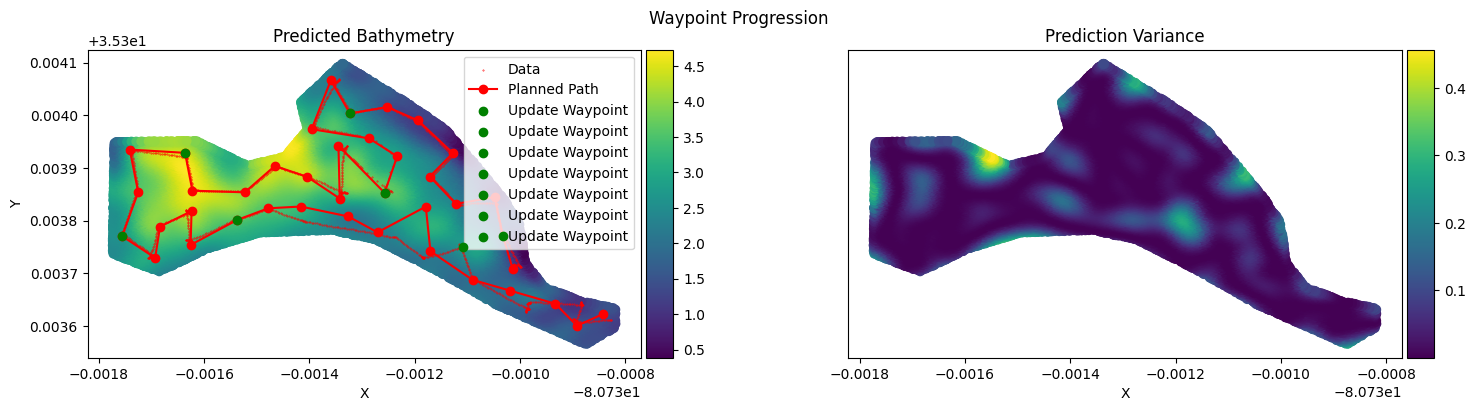

In [34]:
approximation_log = 'IPP-mission-2025-07-16-20-24-56'
# predict and display approximation
y_app = process_data(approximation_log, X_candidates)

In [7]:
for i, y_gt in enumerate(y_gts):
    rmse = get_rmse(y_app, y_gt)
    print(f'RMSE compared to lawnmower path {i+1}: {rmse}')

RMSE compared to lawnmower path 1: 0.43257355054883617
RMSE compared to lawnmower path 2: 0.5512736984437869


In [ ]:
def plot_results(X_candidates, y_candidates, var, 
                 X, waypoints_original, waypoints_final=None,
                 title=None, fname=None, 
                 figsize=(10, 4), update_waypoints=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    # Reconstruction
    map = ax[0].scatter(X_candidates[:, 1], X_candidates[:, 0],
                        c=y_candidates)
    ax[0].scatter(X[:, 1], X[:, 0], c='r', s=0.5, marker='.', label='Data')
    ax[0].plot(waypoints_original[:, 1], waypoints_original[:, 0], marker='o', c='r', label='Planned Path')
    if update_waypoints is not None:
        xs = [waypoints_final[update, 1] for update in update_waypoints]
        ys = [waypoints_final[update, 0] for update in update_waypoints]
        ax[0].scatter(xs, ys, marker='o', c='g', label='Update Waypoints', zorder=10)
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("Y")
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(map, cax=cax, orientation='vertical')
    ax[0].set_title("Predicted Bathymetry")
    ax[0].set_aspect('equal')
    ax[0].legend()


    # Prediction Variance
    map = ax[1].scatter(X_candidates[:, 1], X_candidates[:, 0],
                        c=var)
    ax[1].set_xlabel("X")
    ax[1].set_yticks([])
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(map, cax=cax, orientation='vertical')
    ax[1].set_title("Prediction Variance")
    ax[1].set_aspect('equal')

    if title is not None:
        plt.suptitle(title)
    if fname is not None:

        print("Saving to:", os.path.abspath(fname))
        plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()